1. 의료영상 데이터의 전처리 및 augmentation을 위한 파이프라인 구성이 체계적으로 진행되었는가?	augmentation이 반영된 tf.data.Dataset 구성이 정상적으로 진행되었다.
2. U-Net의 개선 모델을 구현하여 적용 후 기존 U-Net 대비 성능 개선을 확인하였는가?	U-Net 개선 모델의 학습 과정이 정상적으로 진행되었으며, validation meanIoU가 기존 U-Net보다 좋아짐을 확인하였다.
3. 3가지 모델에 대한 학습과정, 테스트 결과를 체계적으로 비교분석하였는가?	loss 그래프, meanIoU 계산, segmentation 결과 시각화 등이 3가지 모델에 대해 수행된 후 결과 비교분석이 제시되었다.

## 데이터 수집 및 Visualization

- 아래와 같이 주요 라이브러리를 로딩해 줍니다.

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

c:\Users\2060\AppData\Local\pypoetry\Cache\virtualenvs\future-an-kjr4oft--py3.10\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.10.0


### 데이터 준비
 - Giana Dataset에서 제공하는 용종 내시경 데이터셋 이용

- 위에서 다운로드한 데이터셋을 학습용과 테스트용으로 분리 
    - 데이터셋의 이미지와 라벨은 각각 train, train_labels 디렉토리에 분리되어 있고 쌍을 이루는 이미지와 라벨의 파일명은 동일 
    - 그리고 사이킷런의 train_test_split을 이용해서 학습(train) 데이터와 테스트(test) 데이터를 분리

In [2]:
DATASET_PATH = 'C:/Users/2060/Downloads/medical_data/aiffel/aiffel/medical'
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [4]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [5]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### Visualization
- 데이터 셋에서 이미지 샘플 5개 확인

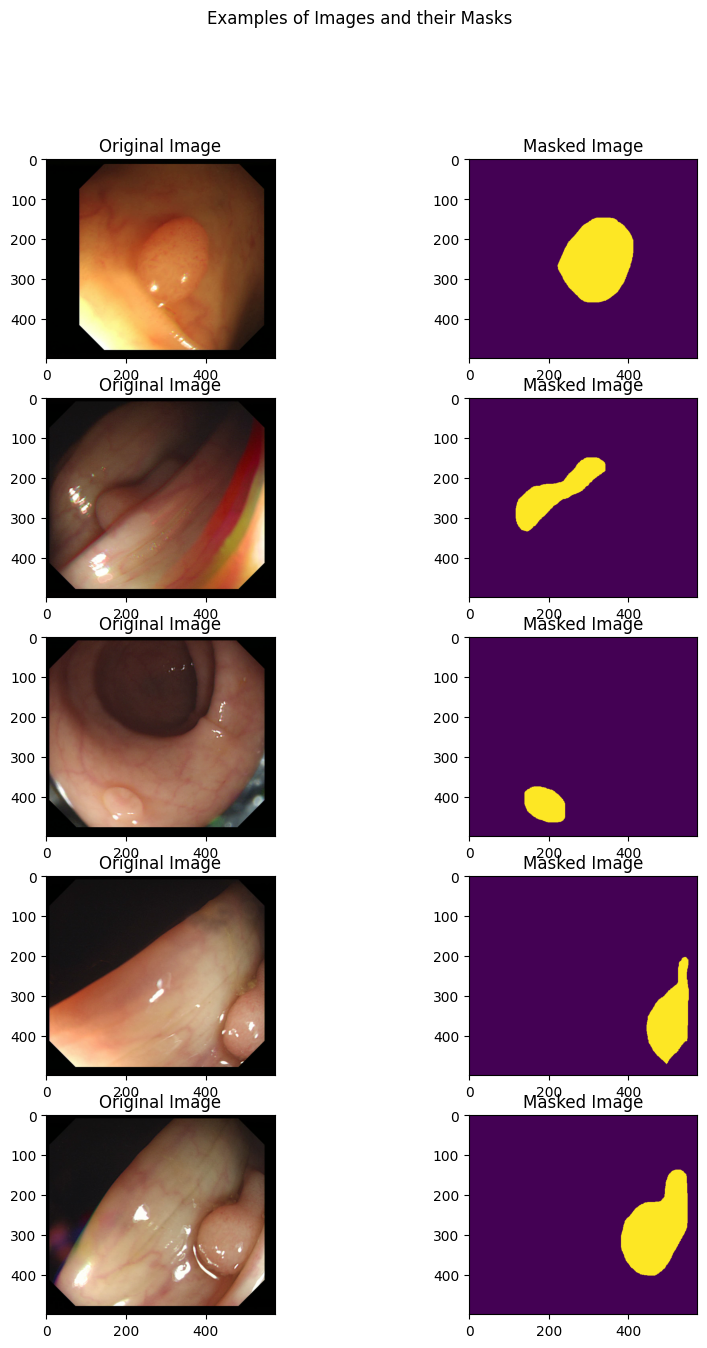

In [6]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

- 라벨은 클래스 값이 아니라 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지

## 15-3. Data pipeline and Preprocessing

### Set up hyper-parameters
- 공통적으로 적용될 하이퍼파라미터를 미리 셋팅해 두겠습니다.

In [7]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 4
max_epochs = 10

### tf.data를 활용한 입력 파이프라인 설계
- tf.data.Dataset을 이용해 데이터셋 구축, 배치처리 등을 진행 
    - 다양한 함수를 map에 적용하여 Data Augmentation을 함께 구현

1. 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지

2. 바이트를 이미지 형식으로 디코딩

3. _augment 함수를 통한 이미지 변환 적용 : (optional, input parameters에 따라서)
    - resize-이미지를 표준 크기로 조정합니다 (eda 또는 계산 / 메모리 제한에 의해 결정됨)

    - resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않기 때문. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야함.

    - 성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있음.

    - *hue_delta-RGB 이미지의 색조를 랜덤 팩터로 조정. 이것은 실제 이미지에만 적용됨.(라벨 이미지가 아님). hue_delta는[0, 0.5]간격에 있어야함.

    - *horizontal_flip-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집습니다. 이 변환은 레이블과 실제 이미지 모두에 적용.

    - *width_shift_range 및 height_shift_range는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부)입니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야함.

    - *rescale-이미지를 일정한 비율로 다시 조정 (예 : 1/255.)

4. 데이터를 섞고, 데이터를 반복하여 학습

#### Data augmentation의 필요성

Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉. 의료영상 처리와 같이 데이터 갯수가 부족한 경우 이런 기법이 큰 힘을 발휘하게 됨.

- 데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"시킵니다.

- 훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없습니다. 따라서 Overfitting을 방지하고, 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줍니다.

#### Processing each pathname

실제 이미지 데이터를 로드하는 함수를 구현. 이 함수 안에서는 다음과 같은 작업을 수행.

- byte 형태로 데이터를 로드하고, bmp로 디코딩합니다.
- 디코딩이 완료된 image를 scale과 size를 조절합니다.

In [8]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### Data augmentation - Shifting the image

아래는 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수. 입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야 함.

In [9]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

#### Data augmentation - Flipping the image randomly

아래는 로드한 이미지를 기반으로 이미지를 flip하는 함수. 50%의 확률로 좌우반전만 구현하였고, 상하반전은 적용하지 않음.

In [10]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

#### Data augmentation Assembling

위에서 구현한 Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성. 위에서 적용한 것들 이외에도 resize, hue_delta가 적용.

In [11]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

### Set up train and test datasets

tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현이때 위에서 만들어온 augmentation도 함께 적용. 단, Train dataset에서만 Data augmentation을 진행하게 설정하는 것에 주의.

In [12]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [13]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

### Plot some train data

지금까지 구성한 학습 데이터를 확인.

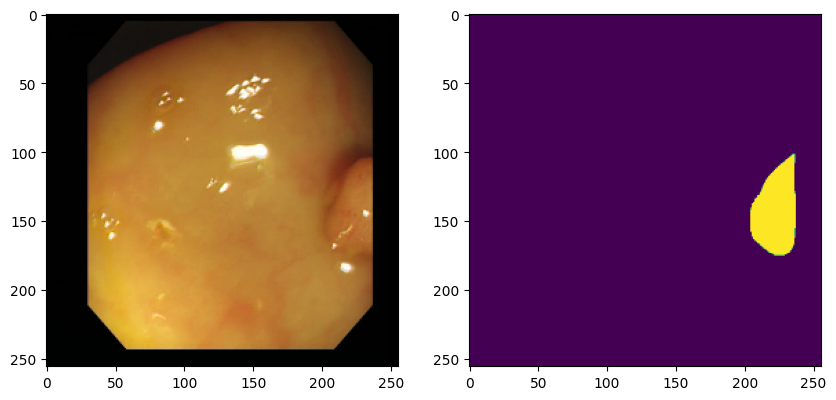

In [14]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## 15-4. Build the model

하나는 Encoder-Decoder 스타일의 네트워크이고 다른 하나는 U-Net

### Encoder-Decoder architecture

- Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작.

- Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label 데이터와 같도록 재생성.

- 이렇게 생성된 데이터와 label 간의 차이가 작아지도록 Encoder와 Decoder의 파라미터들이 End-to-End로 학습.

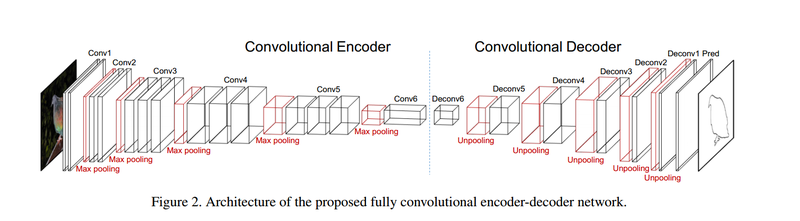

#### Encoder

- input data의 shape가 다음과 같이 되도록 네트워크를 구성.

    - inputs = [batch_size, 256, 256, 3]

    - conv1 = [batch_size, 128, 128, 64]

    - conv2 = [batch_size, 64, 64, 128]

    - conv3 = [batch_size, 32, 32, 256]

    - outputs = [batch_size, 16, 16, 512]

- Convolution - Normalization - Activation 등의 조합을 다양하게 생각해 봅시다.

- Encoder의 차원을 줄여가는 방법으로 Pooling을 쓸지 Convolution with stride=2 로 할지 선택해 볼 수 있음.

- tf.keras.Sequential()을 이용하여 설계

#### Decoder

- Encoder의 mirror 형태로 만들어 봅시다.

- input data의 shape이 다음과 같이 되도록 네트워크를 구성.

    - inputs = encoder의 outputs = [batch_size, 16, 16, 512]

    - conv_transpose1 = [batch_size, 32, 32, 256]

    - conv_transpose2 = [batch_size, 64, 64, 128]

    - conv_transpose3 = [batch_size, 128, 128, 64]
    
    - outputs = [batch_size, 256, 256, 1]

- tf.keras.Sequential()을 이용하여 만들어 봅시다.

In [15]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [16]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(4, 16, 16, 512)


In [17]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [18]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(4, 256, 256, 1)


In [19]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

In [20]:
print('select the Encoder-Decoder model')
model_ed = ed_model
checkpoint_dir_ed =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


### metrics과 loss functions 정의하기

사용할 loss function

- binary cross entropy

- dice_loss

    - Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가해 사용.

    - http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf

    - 논문에 나온 Dice coefficient 수식

- Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있음.

#### Create a encoder-decoder model

이 둘을 결합한 모델은 다음과 같이 간단히 구성할 수 있음.

In [21]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용.

In [22]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성.

In [23]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

### E-D Compile and Callbacks

In [24]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

model_ed.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_ed = model_ed(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_ed.shape)

(4, 256, 256, 1)


In [25]:
model_ed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (4, 16, 16, 512)          4693056   
                                                                 
 decoder (Sequential)        (4, 256, 256, 1)          2354913   
                                                                 
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


- Callback 함수들을 이용하여, 학습 중간에 원하는 동작을 할 수 있도록 함.

    - ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할.

    - LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수.

    - cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현이다.

In [26]:
if not os.path.isdir(checkpoint_dir_ed):
    os.makedirs(checkpoint_dir_ed)

cp_callback_ed = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_ed,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [27]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

### U-Net architecture

U-Net 모델구조는 잘 보면 U-Net 원본과는 약간 차이가 있음. 논문 원본의 구현에서는 padding을 zero로 하기 때문에 Encoder 레이어 대비 Decoder 레이어에 약간의 사이즈 축소가 발생. 그러나 우리는 padding을 same으로 두고 Encoder, Decoder간 대응하는 레이어의 사이즈를 동일하게 가져갈 것입니다. 이것은 크게 성능에 영향을 주지 않으면서도 구현이 용이할 뿐더러 이후 모델의 추가개선을 더욱 쉽게 만들어 주는 장점이 있음.

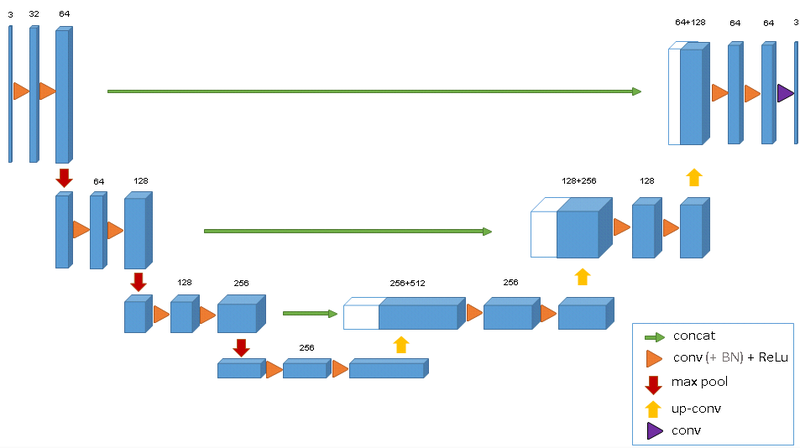

### Model subclassing을 활용한 구현

- U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않음. 이럴때는 위에 Encoder-Decoder 모델처럼 tf.keras.Sequential()을 쓸 수가 없게 됨.

- Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 tf.keras functional API. U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현

In [28]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [29]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [30]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

unet_model = UNet()

In [31]:
print('select the U-Net model')
model_unet = unet_model
checkpoint_dir_unet =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


### unet Compile and callbacks

In [32]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

model_unet.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model_unet(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(4, 256, 256, 1)


In [33]:
model_unet.summary()

Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block (EncoderBlock  multiple                 76416     
 )                                                               
                                                                 
 encoder_block_1 (EncoderBlo  multiple                 444288    
 ck)                                                             
                                                                 
 encoder_block_2 (EncoderBlo  multiple                 1773312   
 ck)                                                             
                                                                 
 encoder_block_3 (EncoderBlo  multiple                 7085568   
 ck)                                                             
                                                                 
 conv_block_4 (ConvBlock)    multiple                  283269

In [34]:
if not os.path.isdir(checkpoint_dir_unet):
    os.makedirs(checkpoint_dir_unet)

cp_callback_unet = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_unet,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [35]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

### Pretrained U-Net 모델

In [36]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs
    
vgg16_model = Vgg16UNet()

In [37]:
print('select the VGG16 model')
model_vgg16 = vgg16_model
checkpoint_dir_vgg16 = os.path.join(DATASET_PATH, 'train_ckpt/vgg16_model')

select the VGG16 model


### vgg16 compile and Callbacks

In [ ]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용
model_vgg16.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_vgg = model_vgg16(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_vgg.shape)

(4, 256, 256, 1)


In [ ]:
model_vgg16.summary()

Model: "vgg16u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 model (Functional)          [(None, 256, 256, 64),    14714688  
                              (None, 128, 128, 128),             
                              (None, 64, 64, 256),               
                              (None, 32, 32, 512),               
                              (None, 16, 16, 512)]               
                                                                 
 conv_block_5 (ConvBlock)    multiple                  0 (unused)
                                                                 
 decoder_block_4 (DecoderBlo  multiple                 9444864   
 ck)                                                             
                                                        

In [41]:
if not os.path.isdir(checkpoint_dir_vgg16):
    os.makedirs(checkpoint_dir_vgg16)

cp_callback_vgg16 = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_vgg16,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [42]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## 15-5. Train your model

모델 학습 이전에, 모델에서 예측한 이미지를 출력할 수 있는 함수를 미리 작성해 모델 성능 테스트에 사용.

In [43]:
## Define print function
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

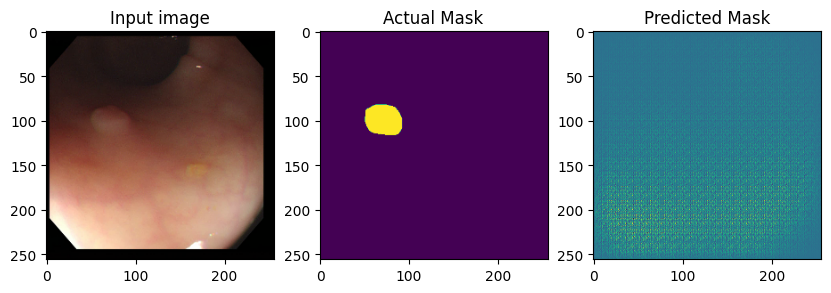

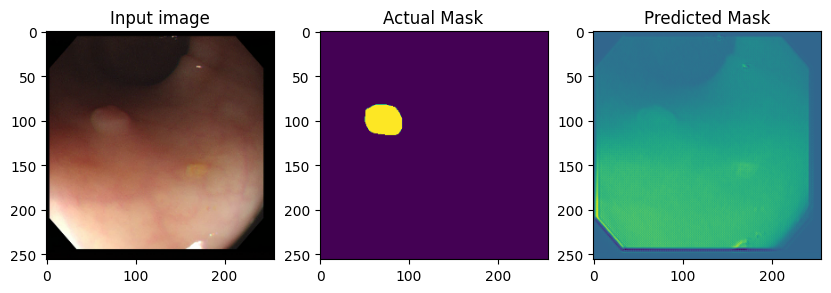

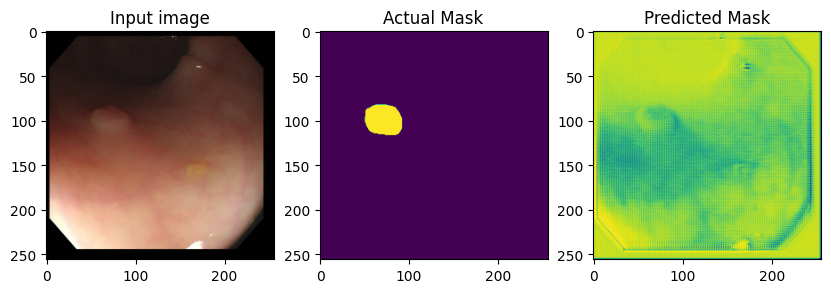

In [44]:
print_images(model_ed)
print_images(model_unet)
print_images(model_vgg16)

### Training - model.fit() 함수 이용

- 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행.

- 학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용할 것이다.

- 아래 코드는 10 Epoch만 학습을 진행한 후, 미리 학습된 모델을 불러온다.

In [45]:
history_ed = model_ed.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_ed, lr_callback]
                    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
60/60 [==============================] - 14s 140ms/step - loss: 1.2963 - dice_loss: 0.8039 - val_loss: 1.3226 - val_dice_loss: 0.8041 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009755282662808895.
Epoch 2/10
60/60 [==============================] - 9s 133ms/step - loss: 1.0378 - dice_loss: 0.7443 - val_loss: 1.0685 - val_dice_loss: 0.7815 - lr: 9.7553e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009045085171237588.
Epoch 3/10
60/60 [==============================] - 9s 133ms/step - loss: 0.9644 - dice_loss: 0.7271 - val_loss: 1.0502 - val_dice_loss: 0.8276 - lr: 9.0451e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007938926573842764.
Epoch 4/10
60/60 [==============================] - 8s 120ms/step - loss: 0.9304 - dice_loss: 0.7084 - val_loss: 1.0757 - val_dice_loss: 0.8684 - lr: 7.9389e-04

Epoch 5: LearningRateScheduler setting

In [46]:
history_unet = model_unet.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_unet, lr_callback]
                    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
60/60 [==============================] - 43s 582ms/step - loss: 0.9908 - dice_loss: 0.7151 - val_loss: 24.2543 - val_dice_loss: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009755282662808895.
Epoch 2/10
60/60 [==============================] - 36s 575ms/step - loss: 0.9116 - dice_loss: 0.6999 - val_loss: 7.7565 - val_dice_loss: 0.9960 - lr: 9.7553e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009045085171237588.
Epoch 3/10
60/60 [==============================] - 34s 543ms/step - loss: 0.9026 - dice_loss: 0.7015 - val_loss: 5.7178 - val_dice_loss: 0.9759 - lr: 9.0451e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007938926573842764.
Epoch 4/10
60/60 [==============================] - 35s 578ms/step - loss: 0.8980 - dice_loss: 0.6965 - val_loss: 1.6034 - val_dice_loss: 0.9261 - lr: 7.9389e-04

Epoch 5: LearningRateScheduler set

In [47]:
history_vgg16 = model_vgg16.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_vgg16, lr_callback]
                    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
60/60 [==============================] - 28s 362ms/step - loss: 1.0107 - dice_loss: 0.7319 - val_loss: 4.5000 - val_dice_loss: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009755282662808895.
Epoch 2/10
60/60 [==============================] - 23s 362ms/step - loss: 0.8920 - dice_loss: 0.6948 - val_loss: 1.0221 - val_dice_loss: 0.7359 - lr: 9.7553e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009045085171237588.
Epoch 3/10
60/60 [==============================] - 22s 354ms/step - loss: 0.8625 - dice_loss: 0.6707 - val_loss: 1.0788 - val_dice_loss: 0.8580 - lr: 9.0451e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007938926573842764.
Epoch 4/10
60/60 [==============================] - 23s 366ms/step - loss: 0.8695 - dice_loss: 0.6795 - val_loss: 0.9147 - val_dice_loss: 0.6972 - lr: 7.9389e-04

Epoch 5: LearningRateScheduler sett

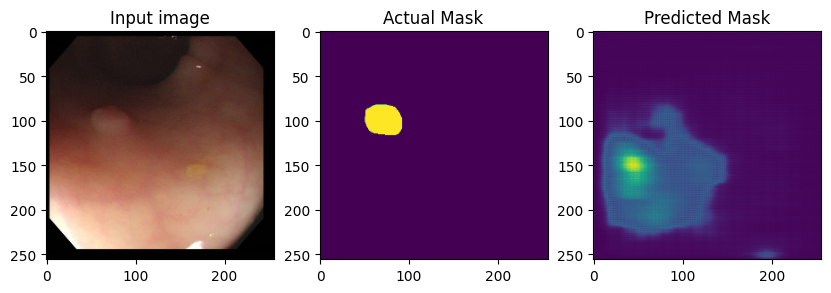

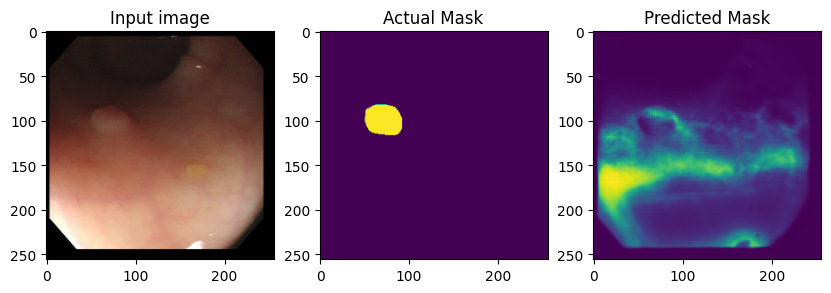

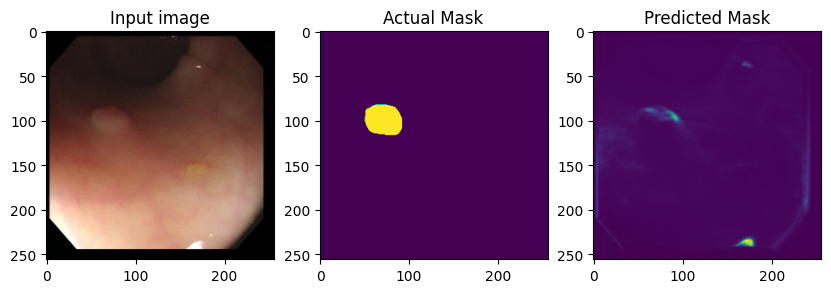

In [48]:
# print sample image after training
print_images(model_ed)
print_images(model_unet)
print_images(model_vgg16)

### Plot the 

저장된 학습 진행과정(history)을 시각화

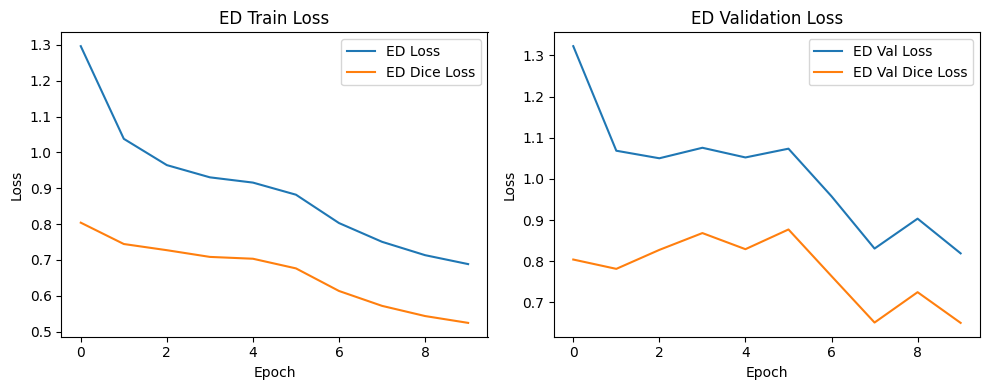

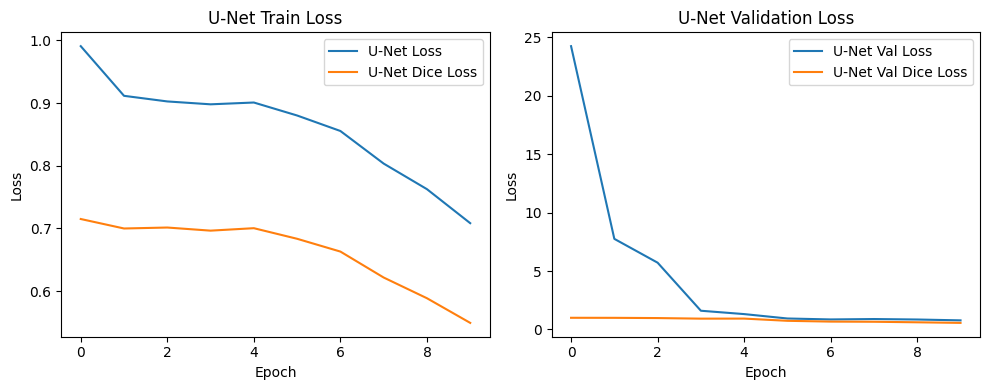

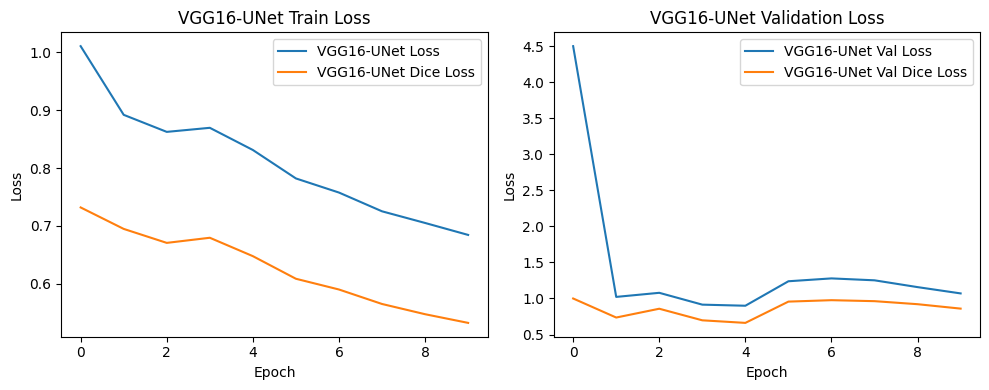

In [61]:
epochs_range = range(max_epochs)

import matplotlib.pyplot as plt

# 1. Encoder-Decoder(ED) 모델
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_ed.history['loss'], label='ED Loss')
plt.plot(epochs_range, history_ed.history['dice_loss'], label='ED Dice Loss')
plt.legend(loc='upper right')
plt.title('ED Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_ed.history['val_loss'], label='ED Val Loss')
plt.plot(epochs_range, history_ed.history['val_dice_loss'], label='ED Val Dice Loss')
plt.legend(loc='upper right')
plt.title('ED Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# 2. U-Net 모델
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_unet.history['loss'], label='U-Net Loss')
plt.plot(epochs_range, history_unet.history['dice_loss'], label='U-Net Dice Loss')
plt.legend(loc='upper right')
plt.title('U-Net Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_unet.history['val_loss'], label='U-Net Val Loss')
plt.plot(epochs_range, history_unet.history['val_dice_loss'], label='U-Net Val Dice Loss')
plt.legend(loc='upper right')
plt.title('U-Net Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# 3. VGG16-UNet 모델
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_vgg16.history['loss'], label='VGG16-UNet Loss')
plt.plot(epochs_range, history_vgg16.history['dice_loss'], label='VGG16-UNet Dice Loss')
plt.legend(loc='upper right')
plt.title('VGG16-UNet Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_vgg16.history['val_loss'], label='VGG16-UNet Val Loss')
plt.plot(epochs_range, history_vgg16.history['val_dice_loss'], label='VGG16-UNet Val Dice Loss')
plt.legend(loc='upper right')
plt.title('VGG16-UNet Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


### Restore the latest checkpoint

저장된 모델의 가중치를 불러옵니다. 직접 학습시킨 모델은 train_ckpt에 저장. 원하는 모델을 불러와 사용.

In [51]:
checkpoint_dir_ed = os.path.join(DATASET_PATH, 'train_ckpt/ed_model')
checkpoint_dir_unet = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')
checkpoint_dir_vgg = os.path.join(DATASET_PATH, 'train_ckpt/vgg_model')

model_ed.load_weights(checkpoint_dir_ed)
model_unet.load_weights(checkpoint_dir_unet)
model_vgg16.load_weights(checkpoint_dir_vgg16)

### Evaluate the test dataset

불러온 가중치를 이용해서 모델을 평가. meanIoU를 metric으로 하여 정량적으로 평가해 볼 수 있고, 실제 생성된 segmentation 이미지를 분석해서 정성적으로 평가해 볼 수 있음.

meanIoU란 각 이미지의 IoU 값을 평균 낸 값. IoU는 segmentation 모델을 정량적으로 평가하는데 좋은 metric.

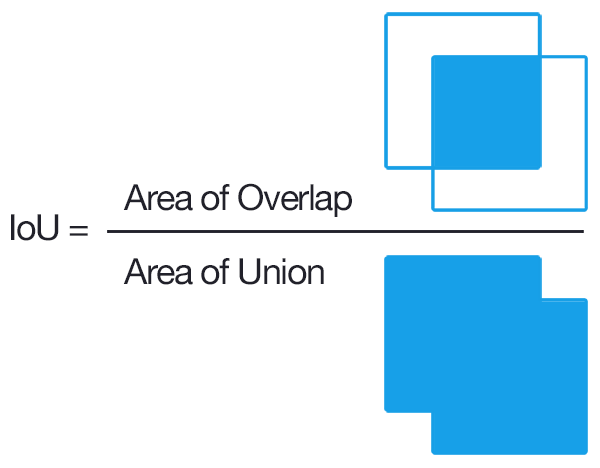

In [52]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

- 테스트 데이터셋을 불러와서 meanIoU 값을 구함. 
- 이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric.

In [58]:
mean_ed = []
mean_unet = []
mean_vgg16 = []

for images, labels in test_dataset:
    predictions_ed = model_ed(images, training=False)
    m_ed = mean_iou(labels, predictions_ed)
    mean_ed.append(m_ed)
    
    predictions_unet = model_unet(images, training=False)
    m_unet = mean_iou(labels, predictions_unet)
    mean_unet.append(m_unet)
    
    predictions_vgg16 = model_vgg16(images, training=False)
    m_vgg16 = mean_iou(labels, predictions_vgg16)
    mean_vgg16.append(m_vgg16)

mean_ed = np.array(mean_ed)
mean_ed = np.mean(mean_ed)
print("mean_iou_ed: {}".format(mean_ed))

mean_unet = np.array(mean_unet)
mean_unet = np.mean(mean_unet)
print("mean_iou_unet: {}".format(mean_unet))

mean_vgg16 = np.array(mean_vgg16)
mean_vgg16 = np.mean(mean_vgg16)
print("mean_iou_vgg16: {}".format(mean_vgg16))

mean_iou_ed: 0.5527573850295455
mean_iou_unet: 0.5735352506593024
mean_iou_vgg16: 0.5081530201720741


- Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인.

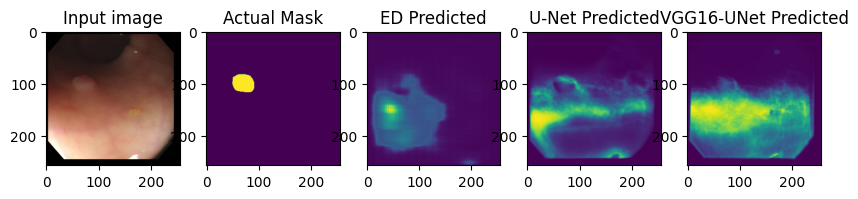

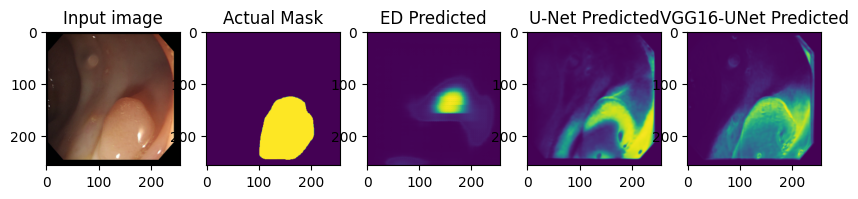

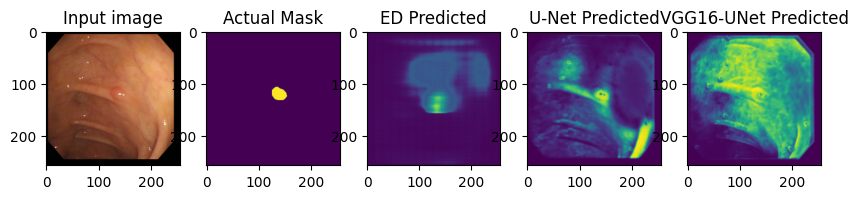

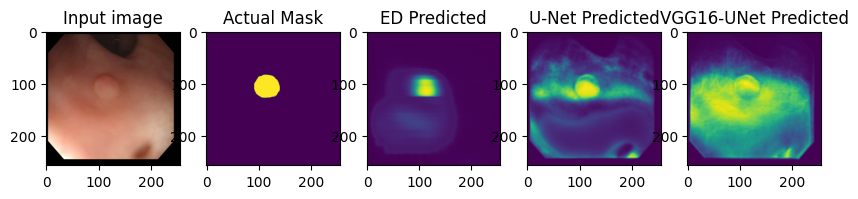

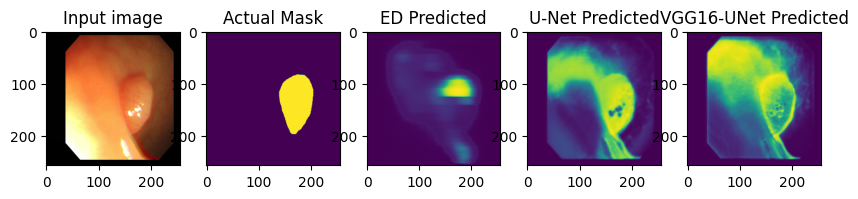

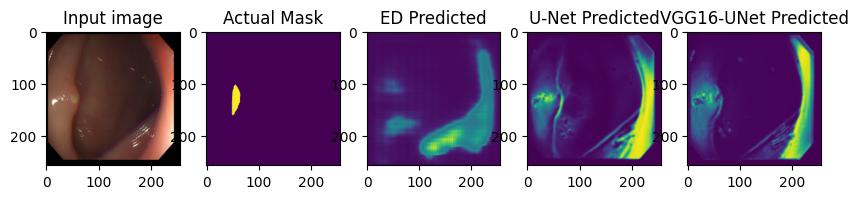

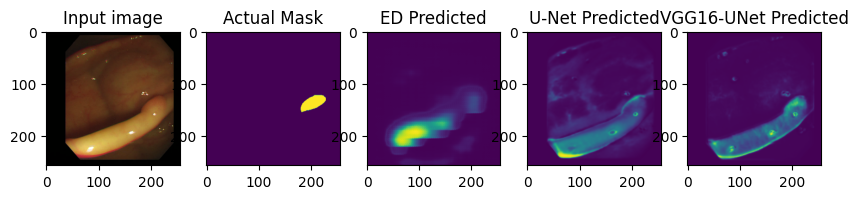

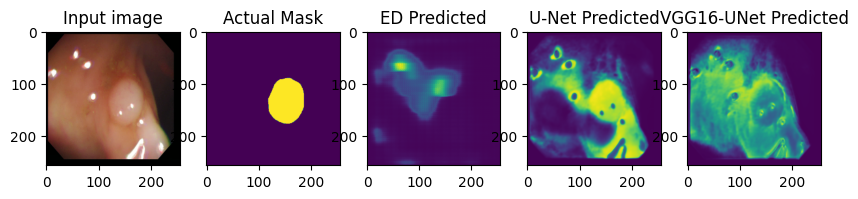

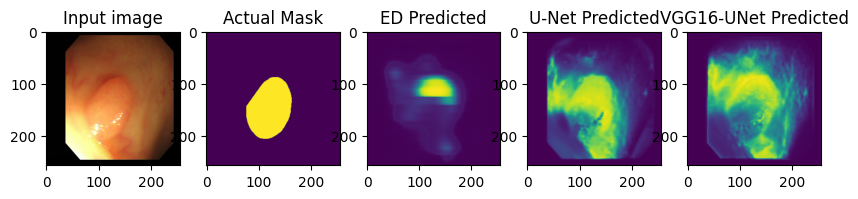

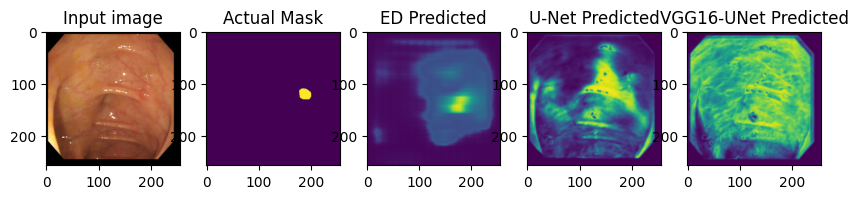

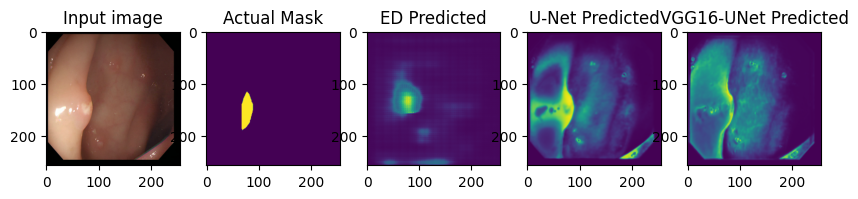

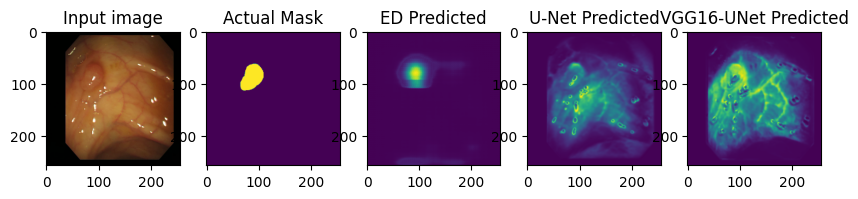

In [70]:
def print_images(num_batches=3):
    batch_count = 0
    for test_images, test_labels in test_dataset:
        predictions_ed = model_ed(test_images, training=False)
        predictions_unet = model_unet(test_images, training=False)
        predictions_vgg16 = model_vgg16(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 5, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title("Input image")

            plt.subplot(1, 5, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 5, 3)
            plt.imshow(predictions_ed[i, :, :, 0])
            plt.title("ED Predicted")

            plt.subplot(1, 5, 4)
            plt.imshow(predictions_unet[i, :, :, 0])
            plt.title("U-Net Predicted")

            plt.subplot(1, 5, 5)
            plt.imshow(predictions_vgg16[i, :, :, 0])
            plt.title("VGG16-UNet Predicted")
            plt.show()
        batch_count += 1
        if batch_count >= num_batches:
            break

print_images(num_batches=3)


- 3가지 모델을 돌려보면서 vgg16 말고도 다른 레이어 출력을 가져와서 decoder와 연결하여 결과를 확인하고 싶어졌다.